# CS-6600 Lecture 23 - Introduction to Recurrent Neural Networks

**Dylan Zwick**

*Weber State University*

Very frequently when making predictions based on data, the data appears in a sequential manner. It could be a sequence of words like "To be or not to be", or a sequence of measurements over time, or even a sequence of music notes. In each of these, there is an ordered, sequential structure to the data that can be useful when making predictions. For example, if I just gave you a random sequence of words "is favorite writer My King" then asked you to find the word that's missing, you might struggle. However, if I gave you "My favorite writer is _______ King", you can probably figure it out because there's additional information in the sequence.

The neural networks we've seen so far aren't built to utilize sequential data. To do so requires a different type of neural network - a specialized neural network called a *recurrent neural network* or an RNN.

In today's class, we'll first look a the fundamental concepts underlying RNNs and how to train them using backpropagation through time, then we'll use them to forecast a time series. We won't get into the main difficulties that RNNs face - unstable gradients and limited short-term memory.

Now, to be clear, RNNs are not the only types of neural networks capable of handling sequential data: for small sequences, a regular dense network can be fine, and for very long sequences convolutional neural networks work quite well too. However, RNNs are usually your best bet when dealing with sequential data, and their basic approach is the foundation for advances in transformer and attention models that are very powerful and which we'll learn about soon.

## Recurrent Neurons and Layers

So far we've only seen feedforward neural networks, where the activations flow in only one direction - from the input layer to the output layer. A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backwards.

Probably the simplest recurrent neural networks possible is one composed of one neuron receiving inputs, producing an output, and sending that output back to itself.

<center>
  <img src="https://drive.google.com/uc?export=view&id=1lvwgoOkI9zyUVJak2x32G4wUZ8kc7_VO" alt="Simple RNN">
</center>

At each *time step* $t$ (also called a *frame*), this *recurrent neuron* receives the inputs $\textbf{x}_{t}$ as well as its own output from the previous time step, $y_{t-1}$. Since there is no previous output at the first time step, it is generally set to $0$. We can visualize what's going on a bit more precisely if we unroll the network through time.

<center>
  <img src="https://drive.google.com/uc?export=view&id=13BF5hV9aOLb8fwzNcIuE5UIUkfqfo6Xj" alt="Unrolled RNN">
</center>

Each recurrent neuron has two sets of weights: one for the inputs $\textbf{x}_{t}$ and the other for the outputs of the previous time step $\textbf{y}_{t-1}$. Let's call these weight vectors $\textbf{w}_{x}$ and $\textbf{w}_{y}$. If we consider an entire recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices $\textbf{W}_{x}$ and $\textbf{W}_{y}$. The output vector of the whole recurrent layer can then be computed pretty much as you might expect, where $\textbf{b}$ is the bias vector and $\phi$ is the activation function:

<center>
    $\displaystyle \textbf{y}_{t} = \phi\left(\textbf{W}_{x}^{T}\textbf{x}_{t} + \textbf{W}_{y}^{T}\textbf{y}_{t-1} + \textbf{b}\right)$
</center>

Note that many researchers prefer to use the hyperbolic tangent (tanh) activation function in RNNs rather than the ReLU or sigmoid.

The output $\textbf{y}_{t}$ is a function of $\textbf{x}_{t}$ and $\textbf{y}_{t-1}$. The value of $\textbf{y}_{t-1}$ is a function of $\textbf{x}_{t-1}$ and $\textbf{y}_{t-2}$. The value of $\textbf{y}_{t-2}$ is a function of $\textbf{x}_{t-3}$ and $\textbf{y}_{t-3}$. This pattern continues, and we see this makes $\textbf{x}_{t}$ a function of all the inputs $\textbf{x}_{t-1}, \textbf{x}_{t-2}, \ldots, \textbf{x}_{1}, \textbf{x}_{0}$. In other words, the output at any time is a function of all the previous inputs.

## Memory Cells

Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of *memory*. A part of a neural network that preserves some state across time steps is called a *memory cell* (or simply a *cell*). A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, usually capable of learning only short patterns (typically about 10 steps long, but this varies depending on the task).

In general a cell's state at time $t$, denoted $\textbf{h}_{t}$ ("h" is for "hidden"), is a function of some inputs at that time and its state at the previous time $\textbf{h}_{t} = f(\textbf{h}_{t-1}, \textbf{x}_{t})$. Its output at time step $t$, denoted $\textbf{y}_{t}$, is also a function of the previous state and the current inputs. For the basic cells we've discussed so far, the output is simply equal to the state, but in more complex cells this isn't the case.

<center>
  <img src="https://drive.google.com/uc?export=view&id=1d-vONycQSL1uTLVBRKCTLCFMIjWhjSjz" alt="Deep RNN">
</center>

## Training RNNs

To train an RNN, the trick is to unroll it through time and then use regular backpropagation. This strategy is called *backpropagation through time* (BPTT).

Just like with regular backpropagation, there is first a forward pass through the unrolled network. Then the output sequence is evaluated using a cost function $C(\textbf{y}_{0}, \textbf{y}_{1}, \ldots, \textbf{y}_{T})$ (where $T$ is the maximum time step). The gradients of that cost function are then propagated backward through the unrolled network. Finally the model parameters are updated using the gradients computed during BPTT. Note the gradients flow backward through all the outputs used by the cost function, not just through the final output.

Fortunately, Keras takes care of all the complexity for you here. So, let's work do an example.

## Forecasting a Time Series

First, let's grab our favorite libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.losses import mean_squared_error

A sequence of numeric data ordered by time is called a *time series*. If there's only one value for each time it's a *univariate time series*. If there's more than one value for each time it's a *multivariate time series*. Using a time series to predict the future is called *forecasting*. Using a time series to fill in gaps from the past is called *imputation*.

We'll create a generate_time_series function:

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

The function creates as many time series as requested (with the batch_size argument), each of length n_steps, and there is just one value per time step in each series, so they're all univariate. The function returns a NumPy array where each series is the sum of two sines waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

Now let's create a training set, a validation set, and a test set:

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

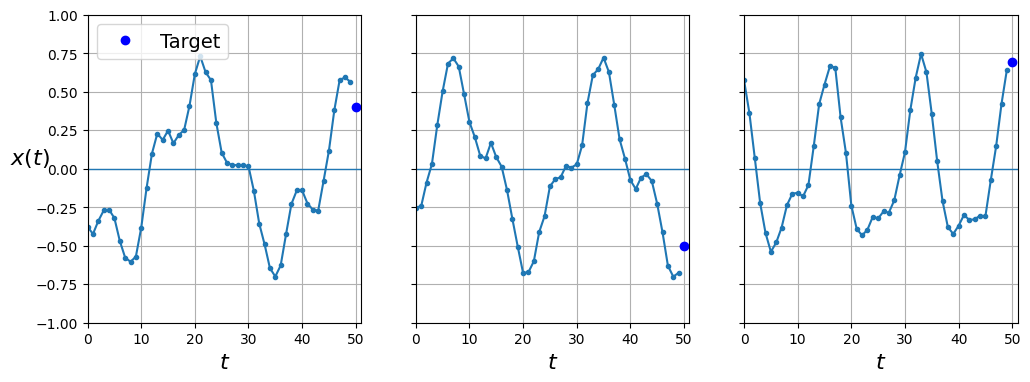

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Since we want to forecast a single value for each series, the targets are column vectors.

### Baseline Metrics

Before we start using RNNs, it's usually a good idea to have a few baseline metrics, or else we may end up thinking our models works great when it's not. For example, the simplest approach is to predict the last value is each series. This is called *naive forecasting*, and it is sometimes surprisingly difficult to outperform. For our data, a naive forecast gives us a mean squared error (mse) of about 0.020:

In [6]:
y_pred = X_valid[:, -1]
np.mean(mean_squared_error(y_valid, y_pred))

0.020211367

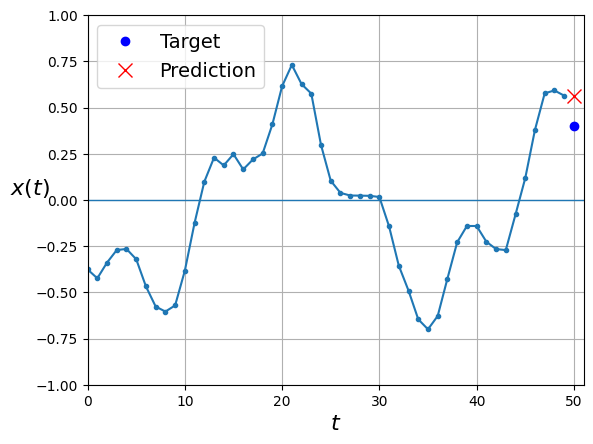

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Let's see if we can beat this with an RNN.

### Implementing a Simple RNN

We can use Keras to implement the simplest RNN imaginable - one with just one neuron.

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We do not need to specify the length of the input sequence, since a recurrent neural network can process any number of time steps (this is why the first dimension is None).

We can compile, fit, and evaluate the model using 20 epochs as follows:

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1031 - val_loss: 0.0214
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0195 - val_loss: 0.0156
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0150 - val_loss: 0.0129
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0128 - val_loss: 0.0117
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8m

In [10]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110


0.010951125994324684

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


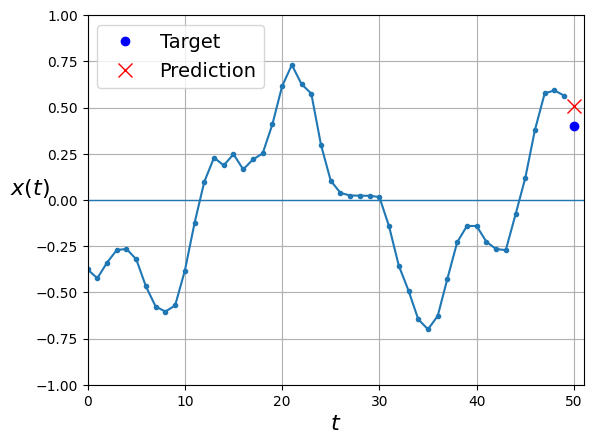

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

This is better than the naive model, but not by a ton. Let's see if we can do better with a more serious RNN.

## Deep RNNs

A deep RNN is one in which multiple layers of cells are stacked.

<center>
  <img src="https://drive.google.com/uc?export=view&id=10-6R7fkMhdMcV0_OOJHamr47IVRoRo9o" alt="Deep RNN">
</center>

Implementing a deep RNN with tf.keras is quite simple, just stack recurrent layers. Here, we'll use three SimpleRNN layers:

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.1548 - val_loss: 0.0104
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0077 - val_loss: 0.0053
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━

In [13]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029


0.0030385854188352823

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


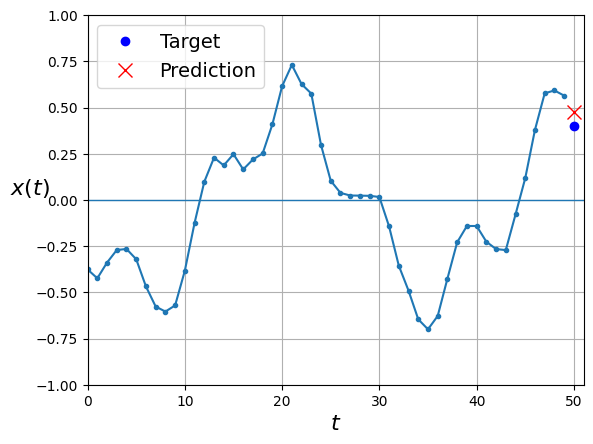

In [14]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Much better!